In [1]:
%%capture
%pip install transformers datasets

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
from tqdm.notebook import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset introduction and pre-processing
The classification task will be done on the IMDB review Dataset. Reviews are either labeled "positive" or "negative". The reviews are also quite long on average, so it will be a good opportunity to observe the performance gained on computation time using Linformer. 

In [4]:
from datasets import load_dataset
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)
print(dataset[0])

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})
{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are 

In [5]:
def preprocessing_fn(x, tokenizer, max_length):
    encoded = tokenizer.encode_plus(
        x["review"],
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,  
        padding="max_length",  
        return_attention_mask=True,  
    )
    # Assign tokenized data and label
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "label": 1 if x["sentiment"] == "positive" else 0,
    }


In [6]:
n_samples = 50000  # The number of training examples
max_length = 512 # The maximum length of the input sequence

# Shuffle the data
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

# Print a sample to verify
print(splitted_dataset[0])

# Remove useless columns 
splitted_dataset = splitted_dataset.select_columns(["input_ids", "attention_mask", "label"])

# Split the train and validation sets
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'review': "The original animated Dark Knight returns in this ace adventure movie that rivals Mask of Phantasm in its coolness. There's a lot of style and intelligence in Mystery of the Batwoman, so much more than Batman Forever or Batman and Robin.<br /><br />There's a new crime-fighter on the streets of Gotham. She dresses like a bat but she's not a grown-up Batgirl. And Batman is denying any affiliation with her. Meanwhile Bruce Wayne has to deal with the usual romances and detective work. But the Penguin, Bain and the local Mob makes things little more complicated.<br /><br />I didn't have high hopes for this 'un since being strongly let down but the weak Batman: Sub Zero (Robin isn't featured so much here!)but I was delighted with the imaginative and exciting set pieces, the clever plot and a cheeky sense of humor. This is definitely a movie no fan of Batman should be without. Keep your ears open for a really catchy song called 'Betcha Neva' which is featured prominently through-o

### DataLoader

In [7]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=max_length, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

batch_size = 32 # GPU can handle this much

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

batch = next(iter(train_dataloader))
print("Input IDs:", batch["input_ids"][1])  
print("Mask:", batch["attention_mask"][1])  
print("Labels:", batch["label"][1])  
print("Input IDs length:", batch["input_ids"][1].size())  
print("Mask length:", batch["attention_mask"][1].size())  
print("Labels length:", batch["label"][1].size())  

Input IDs: tensor([  101,  2206,  1037,  5560,  1021,  2095,  6857,  2346,  2006,  6788,
         1010,  2009,  2001,  2787,  2000,  2079,  2074,  2028,  2197,  3565,
        18932,  1012,  1996,  2186,  2018,  2042,  2006,  1996, 11957,  2195,
         2335,  4283,  2000,  2025,  2383,  1996,  3616,  2008,  2052,  7515,
         2009,  2004,  1037,  3796,  1011, 18396,  1997,  1037,  2694,  3178,
         1012,  2009,  2018,  2467,  2018,  1037, 25908,  1010,  2524,  4563,
         1997,  2524,  3650,  1997,  8771,  1012,  1026,  7987,  1013,  1028,
         1026,  7987,  1013,  1028,  2009,  2001,  2471,  2004,  2065,  1996,
         2186,  2007,  1996,  2440,  2516,  1997,  1000, 18268,  1024,  2166,
         2006,  1996,  2395,  1000,  1006,  2857,  1011,  5585,  1007,  2001,
         1037,  4066,  1997,  1000,  2720,  1012,  1999,  1011,  2090,  1000,
         1997,  2186,  1012,  2009,  2001,  2205,  2502,  2000,  2074, 17542,
         1010,  2021,  2205,  2235,  2000,  2131,  10

## Model Implementation
In this section, we implement a transformer architecture that can use both the traditionnal multi-head Attention and Linformer multi-head Attention

#### Weights initialization

In [8]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

#### Feed-Forward

In [9]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),  
            nn.Dropout(dropout),  
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

#### Classic Multi-Head Self-Attention 

We use masking so that that the model does not attend to padding token 

In [10]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d, n_heads, dropout=0.3):
        super(Multi_Head_Attention,self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"
        
        self.n_heads = n_heads
        self.d_heads = d // n_heads  # Dimension per head

        self.q_proj = nn.Linear(d, d)
        self.k_proj = nn.Linear(d, d)
        self.v_proj = nn.Linear(d, d)
        self.out_proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        batch_size, seq_len, d = x.shape
        d_heads = self.d_heads

        # Linear projections
        Q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        K = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        V = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)

        # Attention scores
        score = Q @ K.transpose(-1, -2) * (d_heads**-0.5)

        # Apply Mask
        if attention_mask is not None:
            expanded_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            score = score.masked_fill(expanded_mask == 0, float('-inf'))

        score = torch.softmax(score, dim=-1)
        score = self.dropout(score) 

        # Attention output
        attention = score @ V  # (batch_size, n_heads, seq_len, d_heads)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, d)  # Merge heads
        out = self.out_proj(attention) 
        return out

#### Linformer Multi-Head Self-Attention

Masking but be done differently here since the score matrix is not of dimension $n*n$ anymore. Instead, we apply the mask to K and V directly

In [11]:
class Multi_Head_Attention_Linformer(nn.Module):
    def __init__(self, input_size, d_heads, d, dim_k, n_heads, dropout):
        super(Multi_Head_Attention_Linformer, self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"

        self.n_heads = n_heads
        self.d_heads = d_heads
        self.dim_k = dim_k
        self.d = d
        self.out_proj = nn.Linear(d, d)

        self.q_proj = nn.Linear(d, d_heads * n_heads)
        self.k_proj = nn.Linear(d, d_heads * n_heads)
        self.v_proj = nn.Linear(d, d_heads * n_heads)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, E, F, attention_mask=None):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        Q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        K = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        V = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)

        if attention_mask is not None:
            mask = attention_mask[:, None, :, None]  # (B, 1, seq_len, 1)
            K = K * mask  
            V = V * mask 

        # Project K and V using E and F
        K = (K.transpose(-2, -1) @ E).transpose(-2, -1)  # (batch_size, n_heads, seq_len, dim_k)
        V = (V.transpose(-2, -1) @ F).transpose(-2, -1)  # (batch_size, n_heads, seq_len, dim_k)

        # Attention scores
        score = (Q @ K.transpose(-2, -1)) * (self.d_heads**-0.5)
        score = torch.softmax(score, dim=-1)
        score = self.dropout(score)

        # Attention output
        attention = score @ V  # (batch_size, n_heads, seq_len, d_heads)
        out = attention.transpose(1, 2).reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, d_heads * n_heads)
        out = self.out_proj(out)
        return out


### Transformer Layer 

In [12]:
class TransformerLayer(nn.Module):
    def __init__(self, d, d_ff, seq_len, k_dim, dropout=0.3, n_heads=8, Linformer_Mode=False):
        super().__init__()

        if Linformer_Mode:
            self.attention = Multi_Head_Attention_Linformer(
                input_size=seq_len, 
                d_heads=d // n_heads, 
                d=d,  
                dim_k=k_dim,  
                n_heads=n_heads,  
                dropout=dropout
            )
        else:
            self.attention = Multi_Head_Attention(d,n_heads, dropout)

        self.feedforward = FeedForward(d, d_ff, d, dropout=dropout)
        self.pre_attention_norm = nn.LayerNorm(d)
        self.post_attention_norm = nn.LayerNorm(d)

    def forward(self, x, attention_mask=None, E=None, F=None):
        
        # Attention with residual connection
        if isinstance(self.attention, Multi_Head_Attention_Linformer):
            attention = self.attention(x, E, F, attention_mask)  # Linformer attention
        else:
            attention = self.attention(x, attention_mask)  # Classic Transformer attention
        y = self.pre_attention_norm(x+attention)
        # Feedforward with residual connection
        ff_y = self.feedforward(y)
        return self.post_attention_norm(y + ff_y)

### Classification Head
The classification head and Transformer Layer will be used by both models. We can easily choose either one by setting Linformer_mode parameter on True or False. We will use the Layerwise sharing of the projections E and F strategy

In [ ]:
class Transformer_Classif(nn.Module):
    def __init__(self, d, d_ff, n_classes, vocab_size, max_len=512, k_dim=128, drop=0.3, num_layers=4, n_heads=8, Linformer_Mode=False):
        super().__init__()
        self.wordembeddings = nn.Embedding(vocab_size, d)
        self.position_embeddings = nn.Embedding(num_embeddings=max_len, embedding_dim=d)  
        self.dropout = nn.Dropout(drop)
        self.max_len = max_len
        self.Linformer_Mode = Linformer_Mode

        # Stack of Transformer Layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d, d_ff, max_len, k_dim, drop, n_heads, Linformer_Mode=Linformer_Mode) for _ in range(num_layers)
        ])
        self.classif = nn.Linear(d, n_classes)
        
        if Linformer_Mode:
        # Linear projection matrices for K and V (Layer Wise Sharing strategy)
            self.E = nn.Parameter(torch.empty(max_len, k_dim))
            self.F = nn.Parameter(torch.empty(max_len, k_dim))
            nn.init.normal_(self.E, mean=0.0, std=0.01)
            nn.init.normal_(self.F, mean=0.0, std=0.01)

        # Weight initialization
        self.apply(initialize_weights)

    def forward(self, x, attention_mask=None):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Truncate input if it exceeds max_len
        if seq_len > self.max_len:
            x = x[:, :self.max_len]  
            attention_mask = attention_mask[:, :self.max_len] if attention_mask is not None else None
            seq_len = self.max_len

        # Word and positional embeddings
        X = self.wordembeddings(x)  # (batch_size, seq_len, d)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_vectors = self.position_embeddings(positions)  # (batch_size, seq_len, d)
        X = self.dropout(X + position_vectors)

        # Loop over Transformer Layers
        for layer in self.transformer_layers:
            if self.Linformer_Mode:
                X = layer(X, attention_mask, self.E, self.F)
            else:
                X = layer(X, attention_mask)

       
        cls_representation = X[:, 0, :]  # (batch_size, d)
        cls_representation = self.dropout(cls_representation)

        # Classification layer
        logits = self.classif(cls_representation)  # (batch_size, n_classes)
        return logits

#### Testing

In [14]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=0,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = False
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[-0.4806, -2.7722],
        [-0.8071,  0.6408],
        [-0.0381,  1.0583],
        [-2.4598,  0.0641],
        [-2.3116,  0.2800],
        [-0.0168,  1.4708],
        [ 0.0298,  2.1673],
        [-1.2734, -1.9449]], grad_fn=<AddmmBackward0>)


In [15]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=128,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = True
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[ 2.4406, -3.4980],
        [-0.8956, -2.0569],
        [-1.0038, -2.1764],
        [ 0.3854, -2.4353],
        [-0.1307, -0.6994],
        [-0.6979, -0.1837],
        [ 1.5396, -0.6961],
        [ 0.7822, -0.3270]], grad_fn=<AddmmBackward0>)


## Training Functions

In [16]:
def compute_accuracy(predictions, labels):
    pred = predictions.argmax(dim=1)  
    correct = (labels == pred).sum().item()
    return correct

def train_one_epoch(dataloader, model, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        
        # Forward pass with attention_mask
        probs = model(batch["input_ids"], attention_mask=batch["attention_mask"]) 
        gold = batch["label"]  

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  
    return avg_loss, avg_accuracy


def validation_step(dataloader, model, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass with attention_mask
            probs = model(batch["input_ids"], attention_mask=batch["attention_mask"])  
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold)
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  
    return avg_loss, avg_accuracy


def train(model, train_dataloader, valid_dataloader, lr=0.0005, n_epochs=3, wd = 1e-4, plot=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
    if plot : 
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="train accuracy")
        plt.plot(valid_accuracies, label="valid accuracy")
        plt.legend()
    return valid_accuracies

## Configuration of the models 

In [17]:
config_classic = {
    "d": 256,
    "d_ff": 4 * 256,
    "vocab_size": 30522,
    "max_len": max_length,  # Can be changed to any value below max_length
    "k_dim": 0,
    "drop": 0.3,
    "num_layers": 4,
    "n_heads": 16,
    "Linformer_Mode": False
}

config_linformer = {
    "d": 256,
    "d_ff": 4 * 256,
    "vocab_size": 30522,
    "max_len": max_length,
    "k_dim": 128,
    "drop": 0.3,
    "num_layers": 4,
    "n_heads": 16,
    "Linformer_Mode": True
}
torch.cuda.empty_cache()

## Training

### Classic Transformer

Number of learnable parameters: 11.10M


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6093, train_accuracy: 68.7000, valid_loss: 0.3452, valid_accuracy: 85.6200


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3378, train_accuracy: 85.4775, valid_loss: 0.2928, valid_accuracy: 87.7300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2687, train_accuracy: 89.0825, valid_loss: 0.2664, valid_accuracy: 89.2600
Time to train : 559.25s


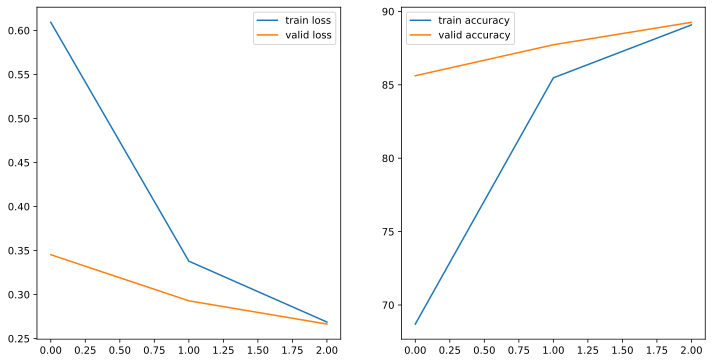

In [18]:
# Initialize model
model_classic = Transformer_Classif(n_classes=2,**config_classic)
model_classic.to(device)

# Number of Parameters 
total_params = sum(p.numel() for p in model_classic.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {total_params / 1e6:.2f}M")

# Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_classic, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")
torch.cuda.empty_cache()

### Linformer model

Number of learnable parameters: 11.24M


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7995, train_accuracy: 50.4025, valid_loss: 0.6892, valid_accuracy: 50.8900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.5032, train_accuracy: 73.7775, valid_loss: 0.3127, valid_accuracy: 87.0500


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2945, train_accuracy: 87.9100, valid_loss: 0.2750, valid_accuracy: 88.7200
Time to train : 267.13s


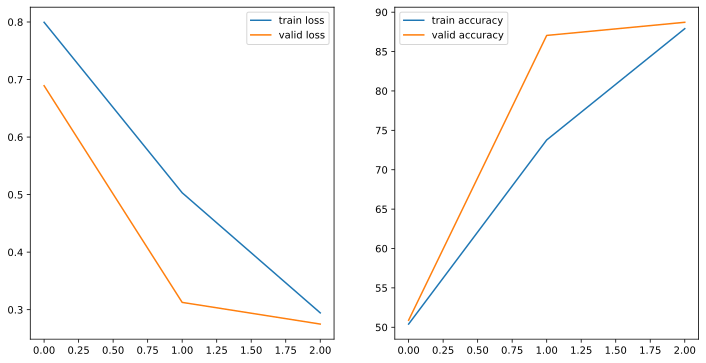

In [19]:
# Initialize model
model_linformer = Transformer_Classif(n_classes=2,**config_linformer)
model_linformer.to(device)

# Number of Parameters 
total_params = sum(p.numel() for p in model_linformer.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {total_params / 1e6:.2f}M")

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_linformer, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")
torch.cuda.empty_cache()

The deeper the model is (more layers) the faster is Linformer compared to the Transformer !

## Ablation Study
In this part, we will study accuracy and computation time for different values of $n$ and $k$. We need to split the data again, but using a training set of size $25000$ and a validation set of size $25000$ to get results that are somewhat more accurate without having to use k-fold cross validation (which would give much more reliable results)

In [20]:
n_samples = 50000  # The number of training examples
max_length = 1024

# Shuffle the data
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

# Remove useless columns 
splitted_dataset = splitted_dataset.select_columns(["input_ids", "attention_mask", "label"])

# Split the train and validation sets
splitted_dataset = splitted_dataset.train_test_split(test_size=0.5)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [21]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=1024, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

batch_size = 16 # GPU can handle this much

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [22]:
ns = [256, 512, 1024]
ks = [64,128,256,512]

results_acc = np.zeros(12)
result_time = np.zeros(12)

i=0
for n in ns:
    config_classic = {
    "d": 256,
    "d_ff": 4 * 256,
    "vocab_size": 30522,
    "max_len": n,
    "k_dim": 0,
    "drop": 0.25,
    "num_layers": 4,
    "n_heads": 8,
    "Linformer_Mode": False
}

    model_classic = Transformer_Classif(n_classes=2,**config_classic)
    model_classic.to(device)
    print("")
    print(f"Classic Transformer : n={n}")
    start_time = time.time()
    acc = np.max(train(model_classic, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3,plot=False))
    torch.cuda.empty_cache()
    end_time = time.time()
    loop_time = (end_time - start_time)
    results_acc[i] = acc
    result_time[i] = loop_time
    i+=1

    for k in ks:

        if (k==512 and n==512) or (k==256 and n==256) or (k==512 and n==256):
            break 

        config_linformer = {
            "d": 256,
            "d_ff": 4 * 256,
            "vocab_size": 30522,
            "max_len": n,
            "k_dim": k,
            "drop": 0.25,
            "num_layers": 4,
            "n_heads": 8,
            "Linformer_Mode": True
        }

        model_linformer = Transformer_Classif(n_classes=2,**config_linformer)
        model_linformer.to(device)
        print("")
        print(f"Linformer : n={n}, k={k}")
        start_time = time.time()
        acc = np.max(train(model_linformer, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3, plot=False))
        torch.cuda.empty_cache()
        end_time = time.time()
        loop_time = (end_time - start_time)
        results_acc[i] = acc
        result_time[i] = loop_time
        i+=1


Classic Transformer : n=256


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6158, train_accuracy: 67.6520, valid_loss: 0.4045, valid_accuracy: 81.2760


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3630, train_accuracy: 84.1160, valid_loss: 0.3179, valid_accuracy: 86.3040


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2899, train_accuracy: 87.8360, valid_loss: 0.3153, valid_accuracy: 86.8800

Linformer : n=256, k=64


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7979, train_accuracy: 49.7200, valid_loss: 0.7000, valid_accuracy: 49.4960


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.5763, train_accuracy: 67.3760, valid_loss: 0.3843, valid_accuracy: 83.5320


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3379, train_accuracy: 86.0560, valid_loss: 0.4965, valid_accuracy: 79.1280

Linformer : n=256, k=128


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7825, train_accuracy: 50.5920, valid_loss: 0.6940, valid_accuracy: 49.4960


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.6509, train_accuracy: 58.4320, valid_loss: 0.4232, valid_accuracy: 81.8120


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3652, train_accuracy: 84.7000, valid_loss: 0.3423, valid_accuracy: 85.7840

Classic Transformer : n=512


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.5833, train_accuracy: 69.9560, valid_loss: 0.3618, valid_accuracy: 84.0120


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3265, train_accuracy: 86.0320, valid_loss: 0.2904, valid_accuracy: 87.9640


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2555, train_accuracy: 89.5720, valid_loss: 0.2929, valid_accuracy: 88.3400

Linformer : n=512, k=64


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7893, train_accuracy: 50.4200, valid_loss: 0.6874, valid_accuracy: 58.4880


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.5567, train_accuracy: 69.4040, valid_loss: 0.3504, valid_accuracy: 85.7120


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3080, train_accuracy: 87.5200, valid_loss: 0.3103, valid_accuracy: 87.4360

Linformer : n=512, k=128


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7800, train_accuracy: 50.6360, valid_loss: 0.6381, valid_accuracy: 63.5280


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4409, train_accuracy: 79.8040, valid_loss: 0.3253, valid_accuracy: 86.5840


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2745, train_accuracy: 88.9880, valid_loss: 0.3095, valid_accuracy: 87.4000

Linformer : n=512, k=256


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7958, train_accuracy: 50.3520, valid_loss: 0.6896, valid_accuracy: 53.6800


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.5416, train_accuracy: 70.0000, valid_loss: 0.3688, valid_accuracy: 85.0440


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3044, train_accuracy: 87.5880, valid_loss: 0.3224, valid_accuracy: 86.6360

Classic Transformer : n=1024


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.5793, train_accuracy: 70.1040, valid_loss: 0.3282, valid_accuracy: 86.1480


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3166, train_accuracy: 86.7440, valid_loss: 0.2809, valid_accuracy: 88.6280


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2416, train_accuracy: 90.2880, valid_loss: 0.2760, valid_accuracy: 89.1320

Linformer : n=1024, k=64


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7948, train_accuracy: 49.9280, valid_loss: 0.6937, valid_accuracy: 50.5800


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.7182, train_accuracy: 51.1080, valid_loss: 0.6945, valid_accuracy: 50.5040


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.6389, train_accuracy: 60.0640, valid_loss: 0.4368, valid_accuracy: 80.1760

Linformer : n=1024, k=128


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.8150, train_accuracy: 49.6200, valid_loss: 0.6955, valid_accuracy: 49.4960


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.6723, train_accuracy: 57.2720, valid_loss: 0.4441, valid_accuracy: 80.6480


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3669, train_accuracy: 84.5720, valid_loss: 0.3142, valid_accuracy: 86.8240

Linformer : n=1024, k=256


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7919, train_accuracy: 50.0200, valid_loss: 0.7033, valid_accuracy: 49.4960


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.5261, train_accuracy: 72.1600, valid_loss: 0.3640, valid_accuracy: 84.9160


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2964, train_accuracy: 88.1680, valid_loss: 0.3230, valid_accuracy: 86.7760

Linformer : n=1024, k=512


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7520, train_accuracy: 55.1800, valid_loss: 0.4370, valid_accuracy: 81.1880


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3828, train_accuracy: 83.2880, valid_loss: 0.3351, valid_accuracy: 86.3440


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2605, train_accuracy: 89.3720, valid_loss: 0.2911, valid_accuracy: 88.3000


In [23]:
import pandas as pd

indices = [
    "Classic Transformer n=256",
    "Linformer n=256 k=64",
    "Linformer n=256 k=128",
    "Classic Transformer n=512",
    "Linformer n=512 k=64",
    "Linformer n=512 k=128",
    "Linformer n=512 k=256",
    "Classic Transformer n=1024",
    "Linformer n=1024 k=64",
    "Linformer n=1024 k=128",
    "Linformer n=1024 k=256",
    "Linformer n=1024 k=512"
]

dataframe = pd.DataFrame({
    "Accuracy": results_acc,
    "Computation Time (s)": result_time
}, index=indices)

dataframe.round(2)

,Accuracy,Computation Time (s)
Classic Transformer n=256,86.88,207.31
Linformer n=256 k=64,83.53,182.82
Linformer n=256 k=128,85.78,244.16
Classic Transformer n=512,88.34,499.68
Linformer n=512 k=64,87.44,232.39
Linformer n=512 k=128,87.40,248.28
Linformer n=512 k=256,86.64,281.64
Classic Transformer n=1024,89.13,923.06
Linformer n=1024 k=64,80.18,331.67
Linformer n=1024 k=128,86.82,359.60


Note : computation time for Linformer n=256, k=128 is an anomaly, GPU was most likely busy with something else at the same time, it can easily be seen by looking at the training logs

## Conclusion : 

From the ablation study, we see that the Linformer is indeed much faster to train, but because of the newly added projections, it can take one epoch or two before it starts learning properly. The more data is used during training, the likelier it will learn from the first epoch. That issue would probably be eliminated if the model was pre-trained, because then those projection would already be in a good configuration from the get go. Otherwise, the Linformer (if given more epochs) and Transformer should perform more or less the same, with the Transformer being slightly better, especially when k is low.

If you do wish to run the Notebook, I suggest changing n_samples and max_length at the beginning of the Notebook to much lower values (Batch size too depending on hardware) and modifying the configuration/learning rate of both models.